(618203, 10)
0.5 0.5
(30857, 15)


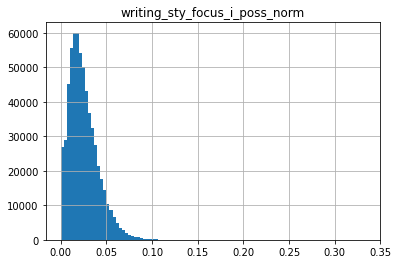

In [1]:
import pandas as pd
import numpy as np


def opposite_jdgmt(judg):
    if "NTA" in judg:
        rtn = judg.replace("NTA", "YTA")
    elif "NAH" in judg:
        rtn = judg.replace("NAH", "ESH")
    elif "YTA" in judg:
        rtn = judg.replace("YTA", "NTA")
    elif "ESH" in judg:
        rtn = judg.replace("ESH", "NAH")
    elif "INFO" in judg:
        rtn = judg

    return rtn+"_neg_vals"

# mapping is either "clip", meaning negative votes are just set to 0, or "oppossite", meaning we use the mapping table in "opposite_jdgmt"
def map_negative_values(df, acros, mapping="clip"):

    if mapping == "opposite" or mapping == "map":
        #print("Map = opposite")
        for k in acros.keys():
            acr = acros[k]

            if k == "info":
                continue

            # create temporary columns containing zeros and only negative votes for each vote type (except info)
            df[acr+"_neg_vals"] = 0
            df.loc[df[acr] < 0, acr+"_neg_vals"] = df[acr]*-1
            df.loc[df[acr] < 0, acr] = 0

        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            # set negative values to 0 & add opposite judgement vote
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]

    elif mapping == "clip":
        #print("Map = clip")
        for k in acros.keys():
            acr = acros[k]
            df.loc[df[acr] < 0, acr] = 0

    return df

def get_correct_posts(post_requirements, df, doFilter=True):
    params = {
        "predict": "ratio",
        "weighted": True,
        "mapping": "map"
    }

    params["ratio"] = 0.5 if params["predict"] == "ratio" else 0.3
    
    ratio = params["ratio"]
    print(1-ratio,ratio)
    keys = ["info", "yta", "nah", "esh", "nta"]
    weight = "weighted_" if params["weighted"] else ""
    values = ["reactions_"+weight+k.upper() for k in keys]
    acros = dict(zip(keys, values))

    df = map_negative_values(df, acros, mapping=params["mapping"])
    if params["predict"] == "ratio":
        tmp = df[acros["yta"]] + df[acros["nah"]] + \
            df[acros["esh"]]+df[acros["nta"]]
        tmp = tmp[tmp != 0]
        tmp = (df[acros["yta"]]+df[acros["esh"]])/tmp
        df["Y"] = tmp

        #WHY DOES THIS REMOVE POSTS?
        if doFilter:
            df = df.loc[(1-ratio <= df["Y"]) | (df["Y"] <= ratio)]
    elif params["predict"] == "class":
        df["YTA_ratio"] = df[acros["yta"]] / \
            (df[acros["info"]] + df[acros["yta"]] +
                df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | (
            (df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]

        # drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio <= df["YTA_ratio"]) | (df["YTA_ratio"] <= ratio)]
        print("CHECK REGARDING FILTERING")

    if doFilter:
        for k, v in post_requirements.items():
            df = df.loc[(df[k] >= v), :]

    #df = df[df.columns.intersection(features_to_analyse+["post_id"])]
    return df

# ["liwc_female", "liwc_discrep", "liwc_home", "writing_sty_focus_i_poss_norm"]
features_to_analyse = ["writing_sty_focus_i_poss_norm", ]
reactions_to_keep = ["reactions_weighted_YTA", "reactions_weighted_NTA",
                     "reactions_weighted_ESH", "reactions_weighted_NAH", "reactions_weighted_INFO"]

post_requirements = {  # requirement: key >= value in post
        "post_num_comments": 10,
        "post_score": 10,
        "post_ratio": 0.7,
    }

#df = pd.read_csv("../datasets/prepend_done.csv")
df = pd.read_csv("../datasets/prepend_done.csv",
                 usecols=features_to_analyse+reactions_to_keep+list(post_requirements.keys())+["post_id"])

df.hist(column=features_to_analyse[0],bins=100)
print(df.shape)
df = get_correct_posts(post_requirements, df, doFilter=True)
print(df.shape)


df_txt = pd.read_csv("../datasets/id_to_text.csv")
#lst = list(filter(lambda x: "sty" in x, list(df.columns)))
# print(lst)


In [3]:
print(list(df.columns))
#df.to_csv("/mnt/c/Users/Philipp/Desktop/dataset_prepend_y_filtered.csv",index=False)

['speaker_author_age', 'speaker_author_gender', 'post_id', 'post_num_comments', 'reactions_weighted_YTA', 'reactions_weighted_NTA', 'reactions_weighted_INFO', 'reactions_weighted_ESH', 'reactions_weighted_NAH', 'reactions_weighted_YTA_neg_vals', 'reactions_weighted_NTA_neg_vals', 'reactions_weighted_INFO_neg_vals', 'reactions_weighted_ESH_neg_vals', 'reactions_weighted_NAH_neg_vals', 'writing_sty_!_count', 'writing_sty_"_count', 'writing_sty_?_count', 'writing_sty_negative_abs', 'writing_sty_trust_abs', 'writing_sty_joy_abs', 'writing_sty_positive_abs', 'writing_sty_fear_abs', 'writing_sty_anger_abs', 'writing_sty_disgust_abs', 'writing_sty_surprise_abs', 'writing_sty_sadness_abs', 'writing_sty_anticipation_abs', 'writing_sty_negative_norm', 'writing_sty_trust_norm', 'writing_sty_joy_norm', 'writing_sty_positive_norm', 'writing_sty_fear_norm', 'writing_sty_anger_norm', 'writing_sty_disgust_norm', 'writing_sty_surprise_norm', 'writing_sty_sadness_norm', 'writing_sty_anticipation_norm', 

## Acros Range

In [1]:
data = []
nr_bins = 21
bin_size = 100/(nr_bins-1)
quantile = 100

if df.length > 380000:
    print("WARNING: we probably want to use the filtered output. Check above to make sure you use doFilter = True. Otherwise we sample posts that our ML model has never seen")

for feat in features_to_analyse:

    min_v = df[feat].min()
    max_v = df[feat].max()
    clipped_df = df
    print(min_v,  max_v)
    print(clipped_df.shape)
    #if quantile < 100:
    #    print(df.shape)
    #    
    #    clipped_df = df[(np.percentile(df[feat], 100-quantile) < df[feat]) & (
    #        df[feat] < np.percentile(df[feat],quantile ))]
    #    print(clipped_df.shape)
    #min_v = clipped_df[feat].min()
    #max_v = clipped_df[feat].max()
    #print(min_v, max_v)
    bin_mins = np.linspace(min_v, max_v, num=nr_bins, endpoint=True)
    decinels = np.linspace(0, 100, num=nr_bins, endpoint=True)

    for i in range(len(bin_mins)-1):
        #print(i,bin_mins[i], bin_mins[i+1] )
        df_sample = clipped_df.loc[((bin_mins[i] <= clipped_df[feat]) &
                            (clipped_df[feat] <= bin_mins[i+1]))]
        if len(df_sample) > 0:
            smpl_id = df_sample['post_id'].sample(n=1, random_state=42).iloc[0]
            smpl_value = str(df_sample[df_sample["post_id"]
                                   == smpl_id][feat].iloc[0])
            smpl_text = df_txt.loc[df_txt["post_id"]
                                   == smpl_id].iloc[0]["post_text"]
            smpl_y = df_sample[df_sample["post_id"]
                                   == smpl_id]["Y"].iloc[0]
        else:
            print(f"No posts found for {feat} from {int(100-i*bin_size)}%")
            smpl_id = "BUCKET EMPTY"
            smpl_value = "-42"
            smpl_text = "NA"

        cur = [feat, f"{int(i*bin_size)}%",
               smpl_value, smpl_y,smpl_id, smpl_text]
        data.append(cur)

np_data = np.array(data)
df_ft_smpl = pd.DataFrame(data=data, columns=[
                          "feature Name", "range", "feature value", "y", "post_id", "post_text"])
df_ft_smpl.to_excel("feature_samples.xlsx", index=False)




NameError: name 'df' is not defined

## Across percentiles

In [2]:
data = []
nr_bins = 21
bin_size = 100/(nr_bins-1)
quantile = 100

for feat in features_to_analyse:

    min_v = df[feat].min()
    max_v = df[feat].max()
    clipped_df = df
    print(min_v,  max_v)
    print(clipped_df.shape)
    print(clipped_df.columns)
    #if quantile < 100:
    #    print(df.shape)
    #    
    #    clipped_df = df[(np.percentile(df[feat], 100-quantile) < df[feat]) & (
    #        df[feat] < np.percentile(df[feat],quantile ))]
    #    print(clipped_df.shape)
    #min_v = clipped_df[feat].min()
    #max_v = clipped_df[feat].max()
    #print(min_v, max_v)
    #bin_mins = np.linspace(min_v, max_v, num=nr_bins, endpoint=True)
    percentiles = np.linspace(0, 100, num=nr_bins, endpoint=True)

    for i in range(len(percentiles)-1):
        #print(i,bin_mins[i], bin_mins[i+1] )
        min_val = np.percentile(clipped_df[feat], percentiles[i])
        max_val = np.percentile(clipped_df[feat], percentiles[i+1])
        df_sample = clipped_df.loc[((min_val <= clipped_df[feat]) &
                            (clipped_df[feat] <= max_val))]
        print(f"Bucket (size {len(df_sample)}) = from: perc [{percentiles[i]}-{percentiles[i+1]}], value [{min_val}-{max_val}]")
        
        
        if len(df_sample) > 0:
            smpl_id = df_sample['post_id'].sample(n=1).iloc[0]
            smpl_value = str(df_sample[df_sample["post_id"]
                                   == smpl_id][feat].iloc[0])
            smpl_text = df_txt.loc[df_txt["post_id"]
                                   == smpl_id].iloc[0]["post_text"]
            smpl_y = df_sample[df_sample["post_id"]
                                   == smpl_id]["Y"].iloc[0]
        else:
            print(f"No posts found for {feat} from {int(100-i*bin_size)}%")
            smpl_id = "BUCKET EMPTY"
            smpl_value = "-42"
            smpl_text = "NA"

        cur = [feat, f"{int(i*bin_size)}%",
               smpl_value, smpl_y,smpl_id, smpl_text]
        data.append(cur)

np_data = np.array(data)
df_ft_smpl = pd.DataFrame(data=data, columns=[
                          "feature Name", "percentile", "feature value", "y", "post_id", "post_text"])
df_ft_smpl.to_excel("feature_samples.xlsx", index=False)

0.0 0.12676056
(30857, 15)
Index(['post_id', 'post_num_comments', 'reactions_weighted_YTA',
       'reactions_weighted_NTA', 'reactions_weighted_INFO',
       'reactions_weighted_ESH', 'reactions_weighted_NAH',
       'writing_sty_focus_i_poss_norm', 'post_score', 'post_ratio',
       'reactions_weighted_YTA_neg_vals', 'reactions_weighted_NAH_neg_vals',
       'reactions_weighted_ESH_neg_vals', 'reactions_weighted_NTA_neg_vals',
       'Y'],
      dtype='object')
Bucket (size 1554) = from: perc [0.0-5.0], value [0.0-0.0048076925]
Bucket (size 1545) = from: perc [5.0-10.0], value [0.0048076925-0.007867828000000006]
Bucket (size 1548) = from: perc [10.0-15.0], value [0.007867828000000006-0.010067114]
Bucket (size 1552) = from: perc [15.0-20.0], value [0.010067114-0.012019231]
Bucket (size 1561) = from: perc [20.0-25.0], value [0.012019231-0.013793103]
Bucket (size 1551) = from: perc [25.0-30.0], value [0.013793103-0.0154639175]
Bucket (size 1571) = from: perc [30.0-35.0], value [0.015463